## 1. Business Understanding

The opioid epidemic continues to pose a serious public health challenge in the United States. EMS agencies are often the first point of contact in opioid-related emergencies, making their data a rich source of insight.

**Goal**: Use EMS data to identify patterns and predictors associated with opioid overdose cases and their outcomes (e.g., field ROSC, transport decisions, ED disposition).

**Stakeholders**: EMS agency leadership, public health officials, policymakers, clinical educators.

**Key Questions**:
- What are the characteristics of opioid overdose patients treated by EMS?
- What factors are associated with improved outcomes (e.g., ROSC, transport to higher-level facilities)?
- How can this data support triage, resource deployment, or public health intervention?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import shap

# Data Understanding

Observations:

65 columns have some missing values.

Some vitals like BGL_std, ETCO2_std, GCS_*_std, etc., have >40–90% missing, which may make them candidates for removal or separate handling.

Core fields like naloxone_administered, resuscitation_flag, etc. have no missing values and are fully populated (possibly due to filtering).

In [8]:
# Load and clean the merged dataset
df = pd.read_csv("../data/interim/opioid_cases_full.csv", low_memory=False)

# Strip tildes and spaces from all object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip(" ~")

print("Data loaded and string columns cleaned. Shape:", df.shape)

Data loaded and string columns cleaned. Shape: (297762, 98)


In [9]:
# Display the first few rows
df.head()

,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,protocols_used,protocol_count,arrest_witnessed_flag,resuscitation_flag,cpr_provided_flag,rosc_flag,dest_rhythm_count,race_count,eResponse_24,eDisposition_18
0,225614082,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914075,1,1,1,1,1,1,1,2224015,7701001
1,225614423,2301053,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
2,225614880,2301079,2302001,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
3,225615710,2301051,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914113,1,1,1,1,1,1,1,2224015,4218015
4,225616308,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914219,1,1,1,1,1,1,1,2224015,7701001


In [10]:
# Display outcome code distribution
df['eOutcome_01'].value_counts(dropna=False).sort_values(ascending=False)

eOutcome_01
7701003    247485
7701001     44600
01           2240
30           1450
09            955
07            315
02            288
65            166
21             88
70             49
20             46
03             22
04             22
66             12
05              8
06              8
62              6
63              1
61              1
Name: count, dtype: int64

In [11]:
# Filter out invalid / unrecorded outcomes
valid_outcomes = df[~df['eOutcome_01'].isin(['7701003', '7701001'])].copy()

# Map codes to official descriptions
outcome_mapping = {
    '01': 'Discharged to home or self care',
    '02': 'Transferred to short-term hospital',
    '03': 'Transferred to skilled nursing facility (SNF)',
    '04': 'Transferred to intermediate care facility (ICF)',
    '05': 'Transferred to other institution',
    '06': 'Home with home health care',
    '07': 'Left against medical advice (AMA)',
    '09': 'Admitted as inpatient',
    '20': 'Deceased / Expired',
    '21': 'Transferred to law enforcement',
    '30': 'Still a patient / outpatient return',
    '43': 'Transferred to federal facility (VA etc.)',
    '50': 'Hospice - home',
    '51': 'Hospice - medical facility',
    '61': 'Transferred within institution (swing bed)',
    '62': 'Transferred to inpatient rehab',
    '63': 'Transferred to long-term care hospital',
    '64': 'Transferred to Medicaid-only nursing facility',
    '65': 'Transferred to psychiatric facility',
    '66': 'Transferred to Critical Access Hospital (CAH)',
    '70': 'Transferred to other healthcare institution',
}

valid_outcomes['eOutcome_01_label'] = valid_outcomes['eOutcome_01'].map(outcome_mapping)

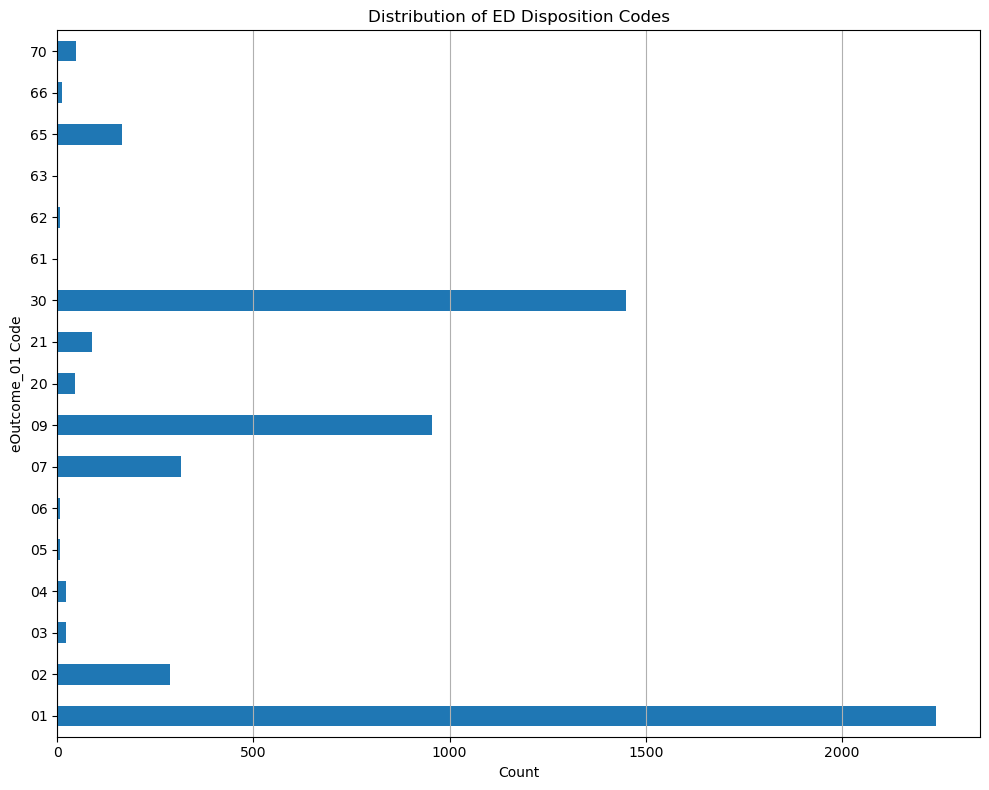

In [12]:
# Distribution of ED outcome codes (after filtering)
valid_outcomes['eOutcome_01'].value_counts().sort_index().plot(kind='barh', figsize=(10, 8))
plt.title('Distribution of ED Disposition Codes')
plt.xlabel('Count')
plt.ylabel('eOutcome_01 Code')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [14]:
# Display human-readable value counts
valid_outcomes['eOutcome_01_label'].value_counts().sort_values(ascending=False)

eOutcome_01_label
Discharged to home or self care                    2240
Still a patient / outpatient return                1450
Admitted as inpatient                               955
Left against medical advice (AMA)                   315
Transferred to short-term hospital                  288
Transferred to psychiatric facility                 166
Transferred to law enforcement                       88
Transferred to other healthcare institution          49
Deceased / Expired                                   46
Transferred to skilled nursing facility (SNF)        22
Transferred to intermediate care facility (ICF)      22
Transferred to Critical Access Hospital (CAH)        12
Transferred to other institution                      8
Home with home health care                            8
Transferred to inpatient rehab                        6
Transferred to long-term care hospital                1
Transferred within institution (swing bed)            1
Name: count, dtype: int64